In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper

In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv,description="Query arxiv papers")
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("attention is all you need")


"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [3]:
api_wrapper_arxiv=WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_arxiv)
print(wiki.name)

wikipedia


In [4]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")



In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily=TavilySearchResults()

/tmp/ipykernel_12456/3543858584.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily=TavilySearchResults()


In [6]:
tavily.invoke("provide me the recent ai news? ")

[{'title': 'AI News | Latest AI News, Analysis & Events',
  'url': 'https://www.artificialintelligence-news.com/',
  'content': 'AI News reports on the latest artificial intelligence news and insights. Explore industry trends from the frontline of AI.',
  'score': 0.6202772},
 {'title': 'AI News & Artificial Intelligence - TechCrunch',
  'url': 'https://techcrunch.com/category/artificial-intelligence/',
  'content': "### [Scale AI confirms ‘significant’ investment from Meta, says CEO Alexandr Wang is leaving](https://techcrunch.com/2025/06/13/scale-ai-confirms-significant-investment-from-meta-says-ceo-alexandr-wang-is-leaving/)\n\n![dripping Facebook Meta logo](https://techcrunch.com/wp-content/uploads/2021/12/dripping-meta-logo.jpg?w=668)\n\n### [The Meta AI app is a privacy disaster](https://techcrunch.com/2025/06/12/the-meta-ai-app-is-a-privacy-disaster/) [...] ### [Taiwan places export controls on Huawei and SMIC](https://techcrunch.com/2025/06/15/taiwan-places-export-controls-on-h

In [7]:
#all tools
tools=[arxiv,wiki,tavily]

In [8]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="qwen-qwq-32b")

In [9]:
llm.invoke("what is Ai?")

AIMessage(content='\n<think>\nOkay, so I need to explain what AI is. Let\'s start with the basics. AI stands for Artificial Intelligence. But what does that really mean? I remember hearing it\'s about making machines smart. But how?\n\nMaybe I should break it down. The term "artificial" means something made by humans, right? And "intelligence" is the ability to learn, understand, reason, and solve problems. So putting them together, AI is when humans create systems that can perform tasks that normally require human intelligence.\n\nWait, but what are those tasks exactly? Like, things like recognizing objects in images, understanding speech, making decisions, playing games, etc. I think there are different types of AI. There\'s weak AI and strong AI. Weak AI is what we have now, like Siri or Alexa, which are designed for specific tasks. They can\'t do anything beyond their programming. Strong AI would be a machine that can do anything a human can do, but I don\'t think we\'re there yet.

In [10]:
llm_with_tools=llm.bind_tools(tools=tools)

In [11]:
##call bind tool
llm_with_tools.invoke("what is recent news on AI?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'hx5wr8epq', 'function': {'arguments': '{"query":"recent news on AI"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 142, 'prompt_tokens': 269, 'total_tokens': 411, 'completion_time': 0.328155477, 'prompt_time': 0.022801031, 'queue_time': 0.820606768, 'total_time': 0.350956508}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_28178d7ff6', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5d208e8c-e806-4c83-8df4-769e7f6142e6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent news on AI'}, 'id': 'hx5wr8epq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 269, 'output_tokens': 142, 'total_tokens': 411})

In [ ]:
#workflow

In [12]:

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage #human message or ai message
from typing import Annotated
from langgraph.graph.message import add_messages ##reducers in langgraph


In [13]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [14]:
##eniter chat bot with graph
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode,tools_condition


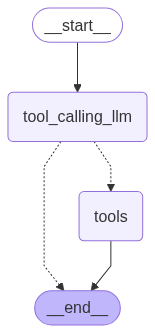

In [20]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

#Build graph

builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

##edges

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools",END)

graph=builder.compile()

#view

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
messages=graph.invoke({"messages":"1706.03762"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (tkqx0m59e)
 Call ID: tkqx0m59e
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [23]:
messages=graph.invoke({"messages":"hi my name is vikas"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

hi my name is vikas
================================== Ai Message ==================================

Hello Vikas! Nice to meet you. How can I assist you today? Feel free to ask me any questions or let me know if you need help with anything specific! 😊


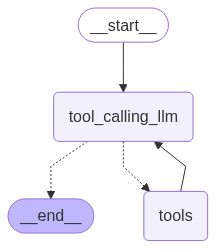

In [24]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

#Build graph

builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

##edges

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools","tool_calling_llm")

graph=builder.compile()

#view

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
messages=graph.invoke({"messages":"what is recent ml news and then please tell me the recent research papper on cloud computing"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is recent ml news and then please tell me the recent research papper on cloud computing
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (d5qbpkmj9)
 Call ID: d5qbpkmj9
  Args:
    query: recent machine learning news
  arxiv (hkfneg0df)
 Call ID: hkfneg0df
  Args:
    query: recent research papers on cloud computing
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Machine Learning & AI recent news | InformationWeek", "url": "https://www.informationweek.com/machine-learning-ai", "content": "GSIMntF243ibDlXIZS7J+lQki7YMoyFP5u0U96LNBpMETmoPEquLQOXCWHqA7xpJjYCp/FpE/HJEGyIe2a7pPxS0ArJjJR9OLlQ1EGrygvR/tUbywpAHyEK3mW69u7LYg0uAFzv0CgAZzEedelMNEpAEAoA9MJQ1w0ZZzE5KZAABAyYyliM3Xvgl0wJIGAICCqSTlrnYNejdgSQMAQIlMDBIEaaB6/BNLGgAASiMm8ukiOGwri4NHSUyTfiLftL4MkQYvkN4SAN